In [1]:
from IPython.display import Image
# get the image
Image(url="photos/foto.png", width=600)

### Importando bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

### Definindo tamanho do mini-batch e seeds

In [ ]:
batch_size = 32

In [ ]:
np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed(111)

### Importando os datasets

In [ ]:
df_train = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_train.csv"
).drop(columns=["Unnamed: 0"])

df_test = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_test.csv"
).drop(columns=["Unnamed: 0"])

X_train = df_train.iloc[:, 0:8].values
y_train = df_train.iloc[:, 8].values

X_test = df_test.iloc[:, 0:8].values
y_test = df_test.iloc[:, 8].values

### Definindo uma classe dataset para converter os dados para tensores

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

### Convertendo os dados para tensores

In [ ]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

### Escrevendo uma função de treinamento

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

def train_model(model, filename_weights):

    # Num epocas
    n_epochs = 100

    # Definindo função custo e otimizador Adam
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Definindo learning rate scheduller
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Array para guardar função custo ao longo das épocas
    train_losses = []
    valid_losses = []

    # Inicializando o early stopping conforme validação
    no_improvement = 0
    no_improvement_threshold = 10
    best_valid_loss = float('inf') 

    # Loop de treinamento
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        
        # Treino
        model.train()
        for data, target in train_loader:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data.float())
            loss = criterion(output, target.view(-1, 1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        # Validação
        model.eval()
        with torch.no_grad():
            for data, target in test_loader:
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
                    
                output = model(data.float())
                loss = criterion(output, target.view(-1, 1).float())
                valid_loss += loss.item() * data.size(0)

        # Calculando média da função custo
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(test_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Implementando o early stopping para evitar overfitting
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), filename_weights)  # salvando o melhor modelo
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement == no_improvement_threshold:
                print("Sem melhoria do custo de validação para {} epochs. Parando treinamento.".format(no_improvement_threshold))
                break

        # Adaptando o learning rate
        scheduler.step()

        # Imprimindo custos de treinamento e validação a cada época
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, train_loss, valid_loss))
        
    return train_losses, valid_losses

### Escrevendo uma função de testes

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def test_model(model,filename_weights):

    # Carregando o modelo especificado pelo nome do arquivo
    model.load_state_dict(torch.load(filename_weights))

    # Colocando o modelo em modo de teste
    model.eval()

    # Fazendo as previsões do modelo
    predictions = []
    targets = []

    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data.float())
            pred = torch.round(torch.sigmoid(output)) #Saída entre 0 e 1
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())

    # Cálculo das métricas
    conf_mat = confusion_matrix(targets, predictions)
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)

    print("Confusion Matrix:\n", conf_mat)
    print("\nAccuracy: ", accuracy)
    print("\nF1 Score: ", f1)


### Definindo um modelo simples para comparação

In [ ]:
import torch.nn as nn

# Definindo o modelo simples para comparação
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        # Um neurônio apenas
        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc(x) #Saída linear para usar a BCEWithLogitsLoss
        return x

# Instanciando o modelo
simple_model = SimpleModel()

if torch.cuda.is_available():
    simple_model = simple_model.cuda()


### Treinando o modelo simples

In [ ]:
filename_weights = 'simple_model.pt'
train_losses, valid_losses = train_model(simple_model, filename_weights)

Epoch: 1 	Training Loss: 5.024106 	Validation Loss: 1.845849
Epoch: 2 	Training Loss: 2.183273 	Validation Loss: 1.709976
Epoch: 3 	Training Loss: 1.705677 	Validation Loss: 1.417295
Epoch: 4 	Training Loss: 1.506630 	Validation Loss: 1.245382
Epoch: 5 	Training Loss: 1.290729 	Validation Loss: 1.107418
Epoch: 6 	Training Loss: 1.156759 	Validation Loss: 0.922620
Epoch: 7 	Training Loss: 1.020169 	Validation Loss: 0.851028
Epoch: 8 	Training Loss: 0.829402 	Validation Loss: 0.723174
Epoch: 9 	Training Loss: 0.845983 	Validation Loss: 0.890208
Epoch: 10 	Training Loss: 0.810122 	Validation Loss: 0.623272
Epoch: 11 	Training Loss: 0.662412 	Validation Loss: 0.626749
Epoch: 12 	Training Loss: 0.646652 	Validation Loss: 0.613690
Epoch: 13 	Training Loss: 0.644170 	Validation Loss: 0.623663
Epoch: 14 	Training Loss: 0.658264 	Validation Loss: 0.606492
Epoch: 15 	Training Loss: 0.639882 	Validation Loss: 0.611631
Epoch: 16 	Training Loss: 0.636922 	Validation Loss: 0.607197
Epoch: 17 	Traini

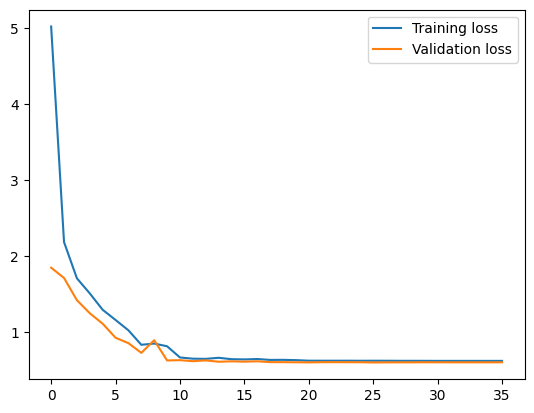

In [ ]:
# Gráficos das funções custo
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.show()

### Testando o modelo simples

In [ ]:
test_model(simple_model, filename_weights)

Confusion Matrix:
 [[84 21]
 [23 26]]

Accuracy:  0.7142857142857143

F1 Score:  0.5416666666666667


### Desenvolvendo um modelo mais complexo

In [ ]:
import torch.nn.functional as F

# Definindo o modelo
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.1)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

# Instanciando o modelo
complex_model = ComplexModel()

if torch.cuda.is_available():
    complex_model = complex_model.cuda()

### Treinando o modelo complexo

In [ ]:
filename_weights = 'complex_model.pt'
train_losses, valid_losses = train_model(complex_model, filename_weights)

Epoch: 1 	Training Loss: 0.701135 	Validation Loss: 0.639605
Epoch: 2 	Training Loss: 0.665230 	Validation Loss: 0.664588
Epoch: 3 	Training Loss: 0.652749 	Validation Loss: 0.627569
Epoch: 4 	Training Loss: 0.642041 	Validation Loss: 0.613958
Epoch: 5 	Training Loss: 0.653079 	Validation Loss: 0.646151
Epoch: 6 	Training Loss: 0.657745 	Validation Loss: 0.637476
Epoch: 7 	Training Loss: 0.636770 	Validation Loss: 0.606306
Epoch: 8 	Training Loss: 0.610391 	Validation Loss: 0.562721
Epoch: 9 	Training Loss: 0.619602 	Validation Loss: 0.600400
Epoch: 10 	Training Loss: 0.591362 	Validation Loss: 0.558874
Epoch: 11 	Training Loss: 0.582794 	Validation Loss: 0.553206
Epoch: 12 	Training Loss: 0.577995 	Validation Loss: 0.553037
Epoch: 13 	Training Loss: 0.579384 	Validation Loss: 0.549401
Epoch: 14 	Training Loss: 0.576594 	Validation Loss: 0.547088
Epoch: 15 	Training Loss: 0.568675 	Validation Loss: 0.544577
Epoch: 16 	Training Loss: 0.586851 	Validation Loss: 0.546862
Epoch: 17 	Traini

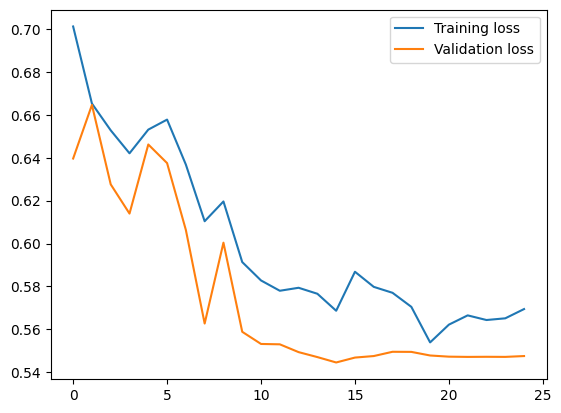

In [ ]:
# Funções custo
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.show()

### Testando o modelo complexo

In [ ]:
test_model(complex_model, filename_weights)

Confusion Matrix:
 [[95 10]
 [28 21]]

Accuracy:  0.7532467532467533

F1 Score:  0.525


### Arquitetura final

A arquitetura do modelo escolhido é 16-32-64-32-12-1 com a função de ativação RELU para as camadas ocultas e uma saída linear, a fim de utilizar a BCEWithLogitsLoss como função custo. 

Foram utilizados os seguintes hyperparâmetros base:
- Learning rate = 0.01;
- Tamanho do batch = 32
- Número de épocas = 100

Para evitar o overfitting, foram utilizadas a seguintes estratégias com os respectivos hyperparâmetros:
- Dropout em todas as camadas com probabilidade = 0.1
- "learning rate scheduler" com step size igual a 10 e gamma igual a 0.1, para evitar os mínimos locais mas diminuir o learning rate com o passar das épocas
- Otimizador Adam
- Validação em paralelo com treinamento
- Early stopping com tolerância de 10 épocas para aguardar queda da função custo de validação.

Para treinamento e teste, foram utilizados os códigos que podem ser visualizados nas funções train_model() e test_model()

### Resultados dos testes
Com a arquitetura final, foi obtido:

A matriz de confusão:

$ \begin{bmatrix}
95 & 10 \\
28 & 21 
\end{bmatrix}  $

F1-Score:  0.525

Acurácia: 0.75


Foi possível obter uma acurácia mediana, mas que pode ser considerada relativamente alta dado o pequeno número de casos de teste e o desbalanceamento dos dados. Uma corretude no diagnóstico de uma doença de 75% não seria suficiente para a utilização médica desse modelo.

Os problemas de uma possível utilização médica desse modelo ficam ainda mais claros quando se observa a matriz de confusão e o F1-Score. Dos 154 dados de treinamento, 28 dos resultados foram falsos negativos (erro do tipo II), o que no contexto considerado seria o erro mais problemático. Além disso, houve 10 casos do tipo I, em que um paciente sem a doença seria diagnosticado corretamente. 116 dos exemplos do treinamento possuem o resultado adequado, (positivo verdadeiro e negativo verdadeiro).

O F1-Score, como média harmônica de precisão e sensibilidade, está longe de 1 e permite representar os resultados não satisfatórios visualizados na matriz de confusão (muitos erros do tipo II) em apenas uma métrica.



### Comparação com resultados obtidos com a regressão logística

No modelo simples com apenas um neurônio e regressão logística, foram obtidos resultados surpeendentes, e relativamente próximos do modelo com a arquitetura final proposta.

A matriz de confusão:

$ \begin{bmatrix}
84 & 21 \\
23 & 26 
\end{bmatrix}  $

F1 Score:  0.542

Acurácia:  0.72

A acurácia obtida com o modelo simples é um pouco menor, mas o F1-Score é um pouco maior do que aquele com o modelo complexo. Além disso, obteve-se menos casos de falso negativo, o que é benéfico no contexto considerado. O problema do modelo mais simples foi apresentar um alto número de falsos positivos, o que indica necessidade de melhorias da arquitetura ou dos hiperparâmetros.

### Conclusão
Portanto, observa-se que um modelo mais complexo nem sempre significará um desempenho muito maior. É necessário cuidado para evitar o overfitting e uma maior experimentação para extrair seu melhor desempenho.

A fim de continuar a aprimoração do modelo desenvolvido, sugere-se a aplicação de um grid search para determinar os melhores hiperparâmetros de maneira sistemática, a fim de melhor especificar uma arquitetura mais profunda.